# BPI Data Client Log Analysis
Enabling logging in your program is equally as important as developing the program. Log files is an example of unstructured data, and analyzing your program log files can provide insight into the health and performance of your program.

This analysis attempts to answer these questions: 
- How performant has the data streaming client been?
- How many errors occured during the program's runtime?
- The program is expected to run continuously every minute, has this been the case?

In [1]:
%pip install pandas
%pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Importing the dataset from CSV
data = pd.read_csv('processed_log.csv')
data.head()

,row,timestamp,log_type,duration
0,1,2023-06-23 17:02,INFO,0.897626
1,2,2023-06-23 17:03,INFO,0.422284
2,3,2023-06-23 17:04,INFO,0.112622
3,4,2023-06-23 17:05,INFO,0.171625
4,5,2023-06-23 17:06,INFO,0.638440


In [4]:
# check the data type in pandas DataFrame
data.dtypes

row            int64
timestamp     object
log_type      object
duration     float64
dtype: object

In [5]:
# data.describe(include='all')
data.describe()

,row,duration
count,18731.000000,18720.000000
mean,9366.000000,0.442380
std,5407.318282,0.595650
min,1.000000,0.039291
25%,4683.500000,0.124821
50%,9366.000000,0.320136
75%,14048.500000,0.532238
max,18731.000000,9.806623


## ETL process duration analysis

In [6]:
# Extracting the 'duration' column
duration_values = data['duration']

In [7]:
# Basic descriptive statistics on the duration field
duration_values.describe()

count    18720.000000
mean         0.442380
std          0.595650
min          0.039291
25%          0.124821
50%          0.320136
75%          0.532238
max          9.806623
Name: duration, dtype: float64

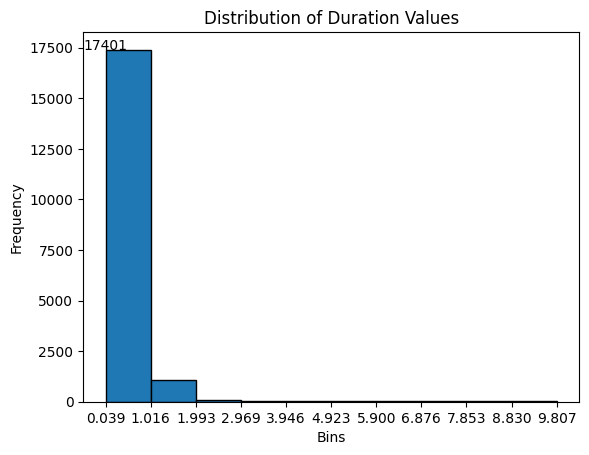

In [8]:
# Plotting a histogram
counts, bins, _ = plt.hist(duration_values, bins=10, edgecolor='black')

# Finding the bin with the highest frequency
max_count = max(counts)
max_index = list(counts).index(max_count)
max_bin = bins[max_index]

# Adding data label for the bin with the highest frequency
plt.text(max_bin, max_count, str(int(max_count)), ha='center')

plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Distribution of Duration Values')
plt.xticks(bins)  # Set the x-axis ticks to the bin values
plt.show()

In [9]:
# the 95th percentile
print(f"{round(duration_values.quantile(0.95), 2)} seconds")

1.15 seconds


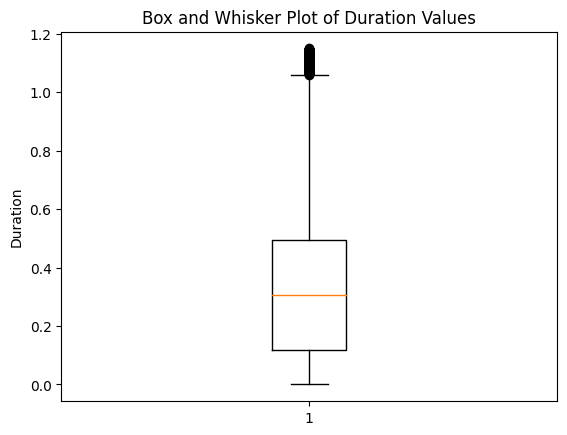

In [10]:
# Replace null values in duration_values with 0
duration_values = duration_values.fillna(0)

# Creating a boolean mask for all duration values within the 95th percentile
mask = duration_values.loc[:] <= duration_values.quantile(0.95)
box_df = duration_values.loc[mask]

# Plotting a box and whisker plot
plt.boxplot([box_df])
plt.ylabel('Duration')
plt.title('Box and Whisker Plot of Duration Values')
plt.show()

In [11]:
# Calculate the quartiles
q75 = duration_values.quantile(0.75)

# Categorize the duration values into four groups
category_labels = ['<75th Percentile', '>=75th Percentile']
categories = pd.cut(duration_values, bins=[float('-inf'), q75, float('inf')], labels=category_labels)

# Perform the count aggregation for each category
duration_counts = categories.groupby(categories).size()

# Print the duration counts for each category
print(duration_counts)

duration
<75th Percentile     14048
>=75th Percentile     4683
Name: duration, dtype: int64


### Findings
The ETL process `typically takes 0.32 seconds` to complete, with `75% of events taking less than 0.53 seconds` to complete. 

The distribution of duration values is `right skewed`, which is also evident comparing the mean and median values, i.e. `median < mean`. The range of `0.039 to 1.016` represents where the bulk of the duration values lie, with a higher concentration in that interval. 

**This suggests that the majority of events or processes represented by the duration values in the log dataset tend to have shorter durations,** with fewer instances of longer durations.


## Process Errors

In [12]:
result = pd.concat([data.head(1), data.tail(1)])
print(result)

         row         timestamp log_type  duration
0          1  2023-06-23 17:02     INFO  0.897626
18730  18731  2023-07-06 17:17     INFO  0.279002


In [13]:
data.groupby('log_type').size()

log_type
INFO    18720
dtype: int64

### Findings
The analysis was conducted with log entries within `2023-06-23 17:02` and `2023-06-23 17:02` GMT, and no errors have been recorded during the program's runtime. 

## Process Runtime Intervals
The program is expected to run continuously every minute, has this been the case? We have to investigate if the timestamps in the dataframe are continuous. 

In [14]:
new_df = data
new_df.head(3)

,row,timestamp,log_type,duration
0,1,2023-06-23 17:02,INFO,0.897626
1,2,2023-06-23 17:03,INFO,0.422284
2,3,2023-06-23 17:04,INFO,0.112622


In [15]:
# Sort the dataframe by timestamp
new_df = new_df.sort_values("timestamp")

# Drop null values from dataframe
new_df = new_df.dropna()
print(f"{data['row'].count() - new_df['row'].count()} rows dropped")

11 rows dropped


In [16]:
# Convert timestamp column to datetime type
new_df["timestamp"] = pd.to_datetime(new_df["timestamp"])
new_df.dtypes

row                   int64
timestamp    datetime64[ns]
log_type             object
duration            float64
dtype: object

In [17]:
new_df['timestamp'].head(2)

0   2023-06-23 17:02:00
1   2023-06-23 17:03:00
Name: timestamp, dtype: datetime64[ns]

In [18]:
# Calculate the expected time difference
expected_diff = new_df["timestamp"].diff().median()
expected_diff

Timedelta('0 days 00:01:00')

In [19]:
# Check for continuity
is_continuous = new_df["timestamp"].diff()[1:] == expected_diff
if is_continuous.all():
    print("The timestamps are continuous.")
else:
    print("The timestamps are not continuous.")

The timestamps are not continuous.


In [20]:
# Identify rows with non-continuous timestamps
is_continuous = new_df["timestamp"].diff() == expected_diff
non_continuous_rows = new_df.loc[~is_continuous]
non_continuous_rows = non_continuous_rows[non_continuous_rows.index != 0]
non_continuous_rows.insert(4, 'flag', 'Non-continuous', True)
non_continuous_rows

,row,timestamp,log_type,duration,flag
4066,4067,2023-06-26 12:49:00,INFO,0.533864,Non-continuous
5420,5421,2023-06-27 11:24:00,INFO,0.626278,Non-continuous
8670,8671,2023-06-29 17:30:00,INFO,1.274357,Non-continuous
8672,8673,2023-06-29 17:32:00,INFO,0.576249,Non-continuous
10816,10817,2023-07-01 05:14:00,INFO,0.980047,Non-continuous
10818,10819,2023-07-01 05:16:00,INFO,0.854864,Non-continuous
14091,14092,2023-07-03 11:51:00,INFO,0.429191,Non-continuous
16214,16215,2023-07-04 23:17:00,INFO,0.258268,Non-continuous
18619,18620,2023-07-06 15:26:00,INFO,0.323946,Non-continuous


In [21]:
# Masking out the preceding non-continuous timestamp rows from the original dataframe
preceding_indices = [(index - 1) for index in new_df.loc[~is_continuous].index if index != 0]
preceding_rows = data.loc[preceding_indices]
preceding_rows.insert(4, 'flag', 'Preceding', True)
preceding_rows["timestamp"] = pd.to_datetime(preceding_rows["timestamp"])
preceding_rows

,row,timestamp,log_type,duration,flag
4065,4066,2023-06-26 12:47:00,INFO,1.412562,Preceding
5419,5420,2023-06-27 11:22:00,INFO,0.272424,Preceding
8669,8670,NaT,NaN,NaN,Preceding
8671,8672,NaT,NaN,NaN,Preceding
10815,10816,NaT,NaN,NaN,Preceding
10817,10818,NaT,NaN,NaN,Preceding
14090,14091,2023-07-03 11:47:00,INFO,0.079156,Preceding
16213,16214,2023-07-04 23:13:00,INFO,0.241826,Preceding
18618,18619,2023-07-06 15:21:00,INFO,0.232752,Preceding


In [22]:
result = pd.concat([non_continuous_rows, preceding_rows])
result.sort_values("row")

,row,timestamp,log_type,duration,flag
4065,4066,2023-06-26 12:47:00,INFO,1.412562,Preceding
4066,4067,2023-06-26 12:49:00,INFO,0.533864,Non-continuous
5419,5420,2023-06-27 11:22:00,INFO,0.272424,Preceding
5420,5421,2023-06-27 11:24:00,INFO,0.626278,Non-continuous
8669,8670,NaT,NaN,NaN,Preceding
8670,8671,2023-06-29 17:30:00,INFO,1.274357,Non-continuous
8671,8672,NaT,NaN,NaN,Preceding
8672,8673,2023-06-29 17:32:00,INFO,0.576249,Non-continuous
10815,10816,NaT,NaN,NaN,Preceding
10816,10817,2023-07-01 05:14:00,INFO,0.980047,Non-continuous


### Findings
There are **only 9 instances of discontinuous timestamps out of 18,731 recorded events.** Although, it is clear that the timestamps are not continuous, but the degree of discontinuity is infinitesimal. 

It is also unclear if there was a logging error, as some preceding timestamps are `NaT` or were not captured or correctly parsed. This reduces the number of clear and recorded incidences to 5. 

So we can conclude that **the program runs continuously every minute for most of the time.**